### XGBOOST

Vemos que el modelo se comporta bien, especialmente después de haber ajustado el threshold. No obstante, Random Forest sigue siendo el ganador.

####  __Autores__: 
####  - González Díaz, Guillermo
  
####  - Sebastiani, Carlos

In [1]:
#importamos algunas librerías
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, roc_curve, recall_score,precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier
from matplotlib import pyplot
import joblib
from aux_func import print_metrics, matriz_confusion, curva_roc, curva_pr, ganancia, curva_lift, print_metrics_optimized,matriz_confusion_optimizada

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Cargamos los data sets y los ponemos en el formato correcto
X_train = pd.read_parquet('../PreprocessingSampled2/X_trainSampled2')
X_test = pd.read_parquet('../PreprocessingSampled2/X_test')
y_train = pd.read_parquet('../PreprocessingSampled2/y_trainSampled2')
y_test = pd.read_csv('../PreprocessingSampled2/y_test').set_index('Unnamed: 0')

In [4]:
# Cargamos el modelo
filename = '../modelos/modeloxgb.sav'
xg_clas = joblib.load(filename)

Hemos porbado con el parámetro scale_pos_weigths = 0.3 para que nos de más importancia a fallar un 1 que a fallar un 0, y aparte de que el tiempo de ejecución ha sido casi el doble, los resultados han sido peores. 

In [5]:
# Tenemos un 30 % de muertes frente a no muertes
(921074 / 3070246) * 100

30.000006514136

### __No correr la siguiente celda si el modelo ha cargado bien antes__

In [ ]:
# Ajustamos el modelo a mano
# 0.1 ha dado  0.114 normal y 0.770 y mil vueltas. 0.1 win rate
xg_clas = xgb.XGBClassifier(objective ='reg:linear',
                            colsample_bytree = 0.3,   
                            learning_rate = 0.1,    
                            max_depth = 10,         
                            alpha = 10,             
                            n_estimators = 500)      

In [ ]:
#xg_clas.fit(X_train, y_train)

In [ ]:
# Guardamos el modelo
#filename = '../modelos/modeloxgb.sav'
#joblib.dump(xg_clas, filename)

In [6]:
y_pred = xg_clas.predict(X_test)
y_pred_proba = xg_clas.predict_proba(X_test)

## Métricas

**Matriz de confusiones** solamente ha acertado un 11.4% de los 1s. Lo cual es bastante bajo en comparación con otros modelos, que han llegado a acertar un 30%, sin haber optimizado parámetros.  <br />
**Curva de ROC** Sabemos que mientras más se aleje la curva de ROC de la diagonal, quiere decir que predice mejor los verdaderos positivos y que disminuye el error de estos. Utilizando las métricas, podemos sacar el treshold que nos ayudará a cambiar el punto en el que vamos a decidir si efectivamente tomamos la probabilidad como un 1 o como un 0. Esto hace que aumentemos el ratio de verdaderos positivos considerablemente.<br />

En este caso vemos que la curva es un poco por a la del modelo ganador. Para el caso de la métrica de la F1, sin optimizar es de 0.55, lo cual es caso como tirar una moneda al aire. Veremos luego como esta métric es optimizada cuado usamos el treshhold. 

**La curva de ganancia** , nos indica que porcentaje de la muestra tenemos que tomar para poder tomar a los 1s que logramos predecir. Vemos que en este caso tomando un 20% de la muestra, llegamos a predecir casi el 70% de los positivos. <br />

**La curva lift**, Nuetra curva de liftsi que mejora en este modelo. Pues esta nos da que tanto impacto tendríamos en la deteccion de 1s, untiliando nuestro modelo versus un modelo random, según se aumenta la muestra. En este caso, vemos que utilizando el modelo, si usamos el 10% de la población, somos capaces de detectar 60 1s más que si no lo usasemos. 
 
***Accuracy** elevado pero un **recall** muy bajo, lo que es indicador que del total de la muestra no detecta muchos accidentes mortales.

Sin embargo, cuando actualizamos el treshold y el F1 score, el recall que son las metricas que nos interesan, mejoran considerablemente. 

Vemos que pasan a un recall de 0.77, y a pesar de que la precision baje, se debe a la perdida en predecir mal los 0s, los cuales en este problema tan desbalanceado, nos son lo más importante. Sin embargo, cabe destacar que habría que aplicar la función de coste para esto, pues pasamos de predecir un 98% los 0s, a un 77%, lo que parece ser bajo. 

In [7]:
print_metrics(y_test, y_pred)

------------------------------------------
The accuracy score is:  0.983
------------------------------------------
The F1 score is:  0.556
------------------------------------------
The recall is:  0.114
------------------------------------------
The precision score is:  0.472


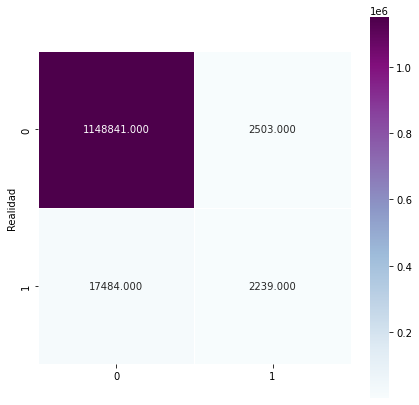

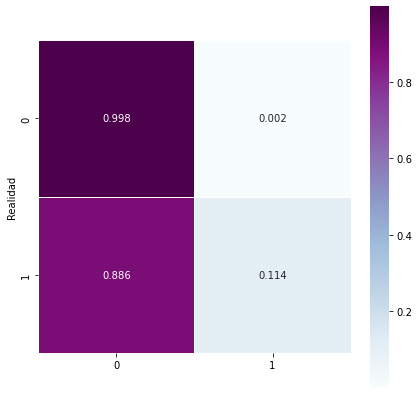

In [8]:
matriz_confusion(y_test, y_pred)

Best Threshold=0.080364, G-Mean=0.771


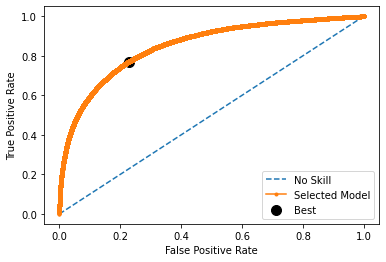

In [9]:
curva_roc(y_test,y_pred_proba)

In [ ]:
#curva_pr(y_test, y_pred_proba)

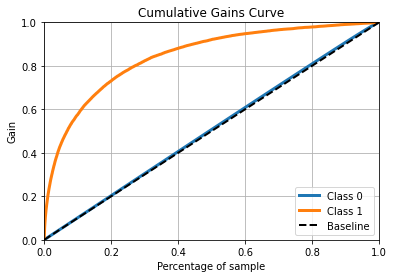

In [10]:
ganancia(xg_clas, y_test, y_pred_proba, X_test)

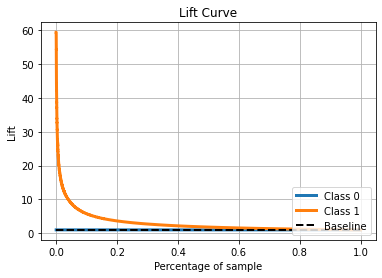

In [11]:
curva_lift(xg_clas, y_test, y_pred_proba, X_test)

### Ajustando el threshold: --------------------------------------------------------------------------
Calculamos el umbral a partir del que obtenemos el mejor balance entre True Positive Rate y False Positive Rate

In [12]:
print_metrics_optimized(xg_clas, X_test, y_test, y_pred_proba)

------------------------------------------
The accuracy score is:  0.773
------------------------------------------
The F1 score is:  0.851
------------------------------------------
The recall is:  0.77
------------------------------------------
The precision score is:  0.055


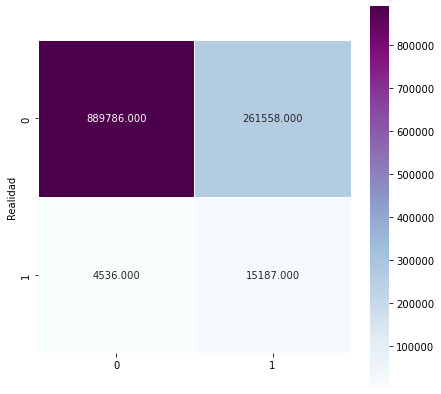

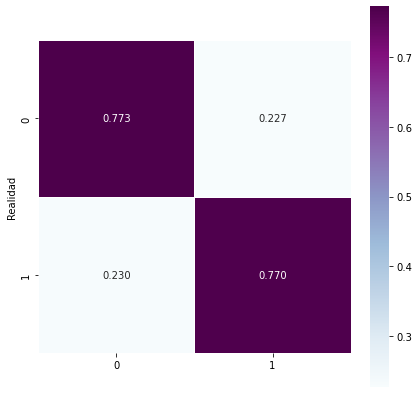

In [13]:
matriz_confusion_optimizada(xg_clas, X_test, y_test, y_pred_proba)